
# Pit Stop Prediction — Advanced Add‑Ons

This notebook extends the pit‑stop project with three features:

1. **Per‑driver label**: build labels at *(driver, lap)* level (pit within next K laps for that driver).
2. **Threshold heatmap**: visualise how precision/recall/alerts count vary with decision threshold.
3. **Feature attribution**: top‑k feature importances and optional SHAP summary (falls back to permutation importance if SHAP unavailable).


In [1]:

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import fastf1
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, average_precision_score,
                             precision_recall_curve, classification_report, confusion_matrix,
                             precision_score, recall_score)
from sklearn.inspection import permutation_importance

print("numpy:", np.__version__)
print("pandas:", pd.__version__)


numpy: 2.1.1
pandas: 2.2.2


## Load session & cache

In [2]:

CACHE_DIR = os.path.expanduser("~/.fastf1")
os.makedirs(CACHE_DIR, exist_ok=True)
fastf1.Cache.enable_cache(CACHE_DIR)

YEAR = 2025
EVENT_NAME = "Austrian Grand Prix"
SESSION_CODE = "R"

session = fastf1.get_session(YEAR, EVENT_NAME, SESSION_CODE)
session.load(laps=True, telemetry=True, weather=True)
print(f"Loaded: {YEAR} {EVENT_NAME} [{SESSION_CODE}]")


core           INFO 	Loading data for Austrian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['4', '81', '16', '44', '63', '30', '14', '5', '27', '31', '87', '6', '10', '18', '43', '22', '23', '1', '12', '55']


Loaded: 2025 Austrian Grand Prix [R]


## Build per‑driver, per‑lap feature table

In [3]:

def extract_driver_lap_features(session):
    laps = session.laps.copy()
    total = float(laps['LapNumber'].max())
    rows = []
    for _, lap in laps.iterlaps():
        try:
            tel = lap.get_car_data()[['Speed']]
            avg_spd = float(tel['Speed'].mean())
            max_spd = float(tel['Speed'].max())
        except Exception:
            avg_spd, max_spd = np.nan, np.nan
        tyre_life = lap.get('TyreLife', np.nan)
        pit_in = int(pd.notna(lap.get('PitInTime', np.nan)))
        lap_frac = float(lap['LapNumber']) / total if total else np.nan
        status = lap.get('TrackStatus', np.nan)
        rows.append({
            'Driver':       lap.get('Driver'),
            'LapNumber':    int(lap.get('LapNumber', 0)),
            'lap_frac':     lap_frac,
            'avg_speed':    avg_spd,
            'max_speed':    max_spd,
            'tyre_life':    float(tyre_life) if pd.notna(tyre_life) else 0.0,
            'pit_in':       pit_in,
            'track_status': str(status) if pd.notna(status) else "0"
        })
    df = pd.DataFrame(rows).sort_values(["Driver","LapNumber"]).reset_index(drop=True)
    return df

df = extract_driver_lap_features(session)
print(df.head())
print("Drivers:", df['Driver'].unique())


  Driver  LapNumber  lap_frac   avg_speed  max_speed  tyre_life  pit_in  \
0    ALB          1  0.014286  150.293333      313.0        1.0       0   
1    ALB          2  0.028571  140.251852      245.0        2.0       0   
2    ALB          3  0.042857  144.621134      282.0        3.0       0   
3    ALB          4  0.057143  213.386029      307.0        4.0       0   
4    ALB          5  0.071429  215.902985      319.0        5.0       0   

  track_status  
0          124  
1            4  
2           41  
3            1  
4            1  
Drivers: ['ALB' 'ALO' 'ANT' 'BEA' 'BOR' 'COL' 'GAS' 'HAD' 'HAM' 'HUL' 'LAW' 'LEC'
 'NOR' 'OCO' 'PIA' 'RUS' 'SAI' 'STR' 'TSU' 'VER']


## Per‑driver label: pit within the next K laps (for that driver)

In [4]:

K = 2  # lookahead horizon
labels = []
for drv, g in df.groupby("Driver"):
    g = g.sort_values("LapNumber")
    # pit flag for this driver on each lap
    pit_on_lap = g.set_index("LapNumber")["pit_in"].reindex(range(g["LapNumber"].min(), g["LapNumber"].max()+1)).fillna(0).astype(int)
    y_drv = []
    for t in g["LapNumber"]:
        future = range(t+1, t+K+1)
        y_drv.append(int(pit_on_lap.reindex(future).fillna(0).sum() > 0))
    gg = g.copy()
    gg["y_pit_nextK"] = y_drv
    labels.append(gg)

df_drv = pd.concat(labels, ignore_index=True)
# Drop last K laps per driver (no full label)
df_drv = df_drv.groupby("Driver", group_keys=False).apply(lambda x: x[x["LapNumber"] <= x["LapNumber"].max()-K]).reset_index(drop=True)
print(df_drv.head())
print("Positives:", int(df_drv["y_pit_nextK"].sum()), "/", len(df_drv))


  Driver  LapNumber  lap_frac   avg_speed  max_speed  tyre_life  pit_in  \
0    ALB          1  0.014286  150.293333      313.0        1.0       0   
1    ALB          2  0.028571  140.251852      245.0        2.0       0   
2    ALB          3  0.042857  144.621134      282.0        3.0       0   
3    ALB          4  0.057143  213.386029      307.0        4.0       0   
4    ALB          5  0.071429  215.902985      319.0        5.0       0   

  track_status  y_pit_nextK  
0          124            0  
1            4            0  
2           41            0  
3            1            0  
4            1            0  
Positives: 64 / 1090


C:\Users\ruizc\AppData\Local\Temp\ipykernel_20684\2086020060.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_drv = df_drv.groupby("Driver", group_keys=False).apply(lambda x: x[x["LapNumber"] <= x["LapNumber"].max()-K]).reset_index(drop=True)


## Prepare features (one‑hot status, add simple weather)

In [5]:

X = df_drv[["Driver","LapNumber","lap_frac","avg_speed","max_speed","tyre_life"]].copy()
# Driver one-hot can help per-driver modeling
X = pd.get_dummies(X, columns=["Driver"], prefix="drv")

# Track status one-hot (per row)
ts_ohe = pd.get_dummies(df_drv["track_status"], prefix="status")
X = pd.concat([X, ts_ohe], axis=1)

# Simple session-level weather
wdf = session.weather_data.copy()
if wdf is not None and not wdf.empty:
    X["air_temp"]   = float(wdf["AirTemp"].dropna().iloc[0])
    X["track_temp"] = float(wdf["TrackTemp"].dropna().iloc[0])
    X["wind_speed"] = float(wdf["WindSpeed"].dropna().iloc[0])
else:
    X["air_temp"] = X["track_temp"] = X["wind_speed"] = 0.0

y = df_drv["y_pit_nextK"].astype(int).values
print("Feature shape:", X.shape)


Feature shape: (1090, 30)


## Train classifier

In [6]:

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

clf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1,
    class_weight="balanced"
)
clf.fit(X_train, y_train)

proba = clf.predict_proba(X_test)[:,1]
pred  = (proba >= 0.5).astype(int)

roc = roc_auc_score(y_test, proba)
ap  = average_precision_score(y_test, proba)
print(f"ROC-AUC: {roc:.3f} | PR-AUC: {ap:.3f}")
print(classification_report(y_test, pred, digits=3))


ROC-AUC: 0.887 | PR-AUC: 0.506
              precision    recall  f1-score   support

           0      0.945     1.000     0.972       257
           1      1.000     0.062     0.118        16

    accuracy                          0.945       273
   macro avg      0.972     0.531     0.545       273
weighted avg      0.948     0.945     0.922       273



## Threshold heatmap: precision/recall/alerts vs threshold

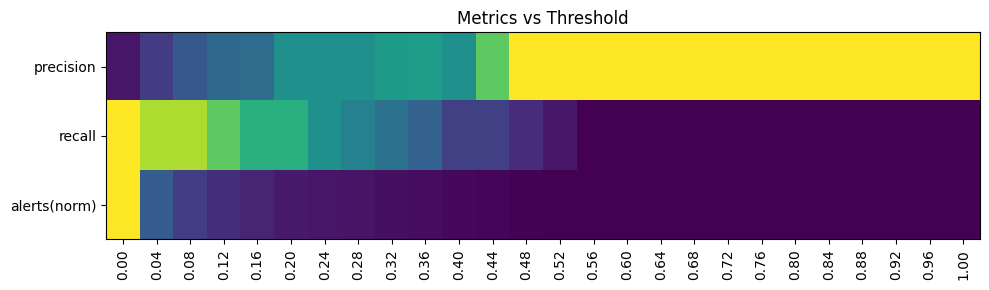

In [7]:

thresholds = np.linspace(0.0, 1.0, 26)  # 0.00 to 1.00 step 0.04
prec_list, rec_list, alerts_list = [], [], []

for th in thresholds:
    p = (proba >= th).astype(int)
    if p.sum() == 0:
        prec = 1.0  # define precision=1.0 when no positive predicted
    else:
        prec = precision_score(y_test, p, zero_division=1)
    rec = recall_score(y_test, p, zero_division=0)
    prec_list.append(prec)
    rec_list.append(rec)
    alerts_list.append(int(p.sum()))

# Build a small matrix (rows: metrics, cols: thresholds) for heatmap
M = np.vstack([prec_list, rec_list, np.array(alerts_list) / max(1, max(alerts_list))])
fig, ax = plt.subplots(figsize=(10, 3))
im = ax.imshow(M, aspect='auto')
ax.set_yticks([0,1,2], labels=['precision','recall','alerts(norm)'])
ax.set_xticks(range(len(thresholds)))
ax.set_xticklabels([f"{t:.2f}" for t in thresholds], rotation=90)
ax.set_title("Metrics vs Threshold")
fig.tight_layout()
plt.show()


## Feature attribution (top‑k importances; optional SHAP)

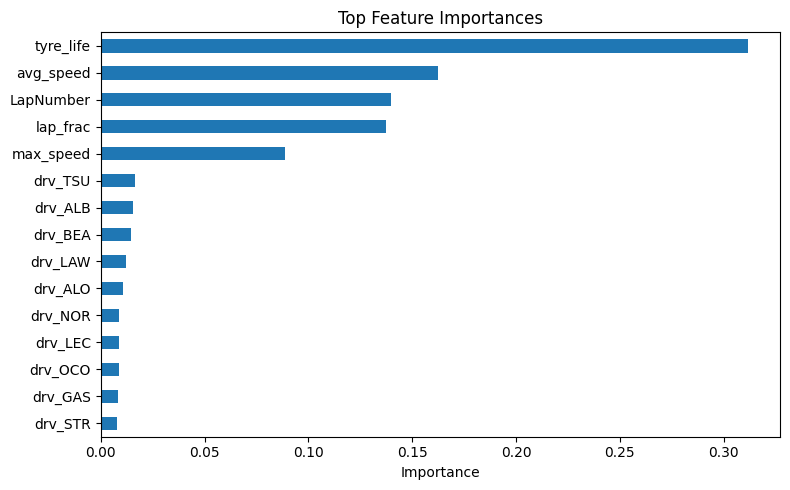

tyre_life    0.311540
avg_speed    0.162613
LapNumber    0.139624
lap_frac     0.137185
max_speed    0.088539
drv_TSU      0.016689
drv_ALB      0.015693
drv_BEA      0.014401
drv_LAW      0.012359
drv_ALO      0.010588
drv_NOR      0.008967
drv_LEC      0.008819
drv_OCO      0.008805
drv_GAS      0.008436
drv_STR      0.007652
dtype: float64

In [8]:

importances = pd.Series(clf.feature_importances_, index=X.columns).sort_values(ascending=False)
topk = importances.head(15)
plt.figure(figsize=(8,5))
topk[::-1].plot(kind='barh')
plt.xlabel("Importance")
plt.title("Top Feature Importances")
plt.tight_layout()
plt.show()
topk


SHAP not available or failed: No module named 'shap'
Falling back to permutation importance...


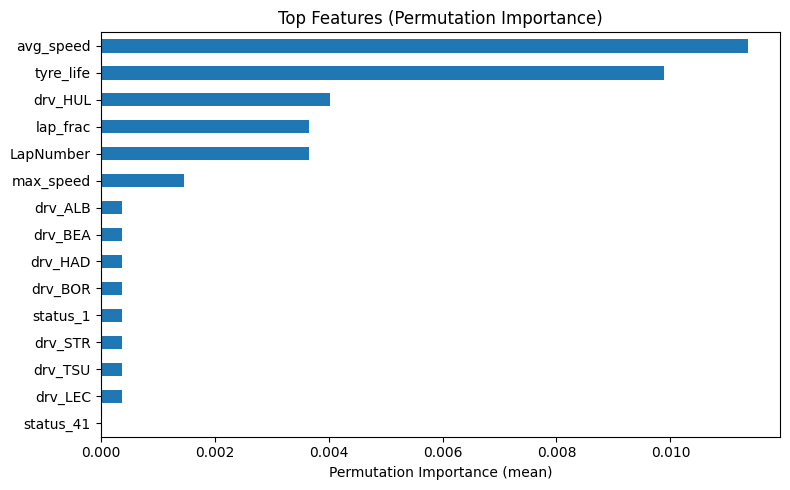

In [9]:

# Optional SHAP summary (fallback to permutation importance if shap not available)
try:
    import shap
    explainer = shap.TreeExplainer(clf)
    # shap expects array; use a subsample for speed
    idx = np.random.choice(len(X_test), size=min(300, len(X_test)), replace=False)
    shap_values = explainer.shap_values(X_test.iloc[idx])
    # For RandomForestClassifier, shap_values is list [class0, class1]; use class1
    sv = shap_values[1] if isinstance(shap_values, list) else shap_values
    shap.summary_plot(sv, X_test.iloc[idx], show=False)
    plt.title("SHAP summary (subsample)")
    plt.tight_layout()
    plt.show()
except Exception as e:
    print("SHAP not available or failed:", e)
    print("Falling back to permutation importance...")
    pi = permutation_importance(clf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
    pi_series = pd.Series(pi.importances_mean, index=X.columns).sort_values(ascending=False).head(15)
    plt.figure(figsize=(8,5))
    pi_series[::-1].plot(kind='barh')
    plt.xlabel("Permutation Importance (mean)")
    plt.title("Top Features (Permutation Importance)")
    plt.tight_layout()
    plt.show()
    pi_series
